In [52]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import faiss
from vendi_score import vendi

scores_path = '/mnt/data/data-selection/data/processed/cohere/scores.jsonl'
data_path = '/mnt/data/data-selection/data/processed/cohere/cohere_data.jsonl'
embedding_cache_path = '/mnt/data/data-selection/data/processed/cohere/Llama-2-7b-hf-tulu_user_only-embeddings.npy'

indices_path = {
    'random': '/mnt/data/data-selection/selection/indices/cohere_Random_0.05_Llama-2-7b-hf.pkl',
    'KMeansRandom': '/mnt/data/data-selection/selection/indices/cohere_KMenasRandomDeita_0.05_Llama-2-7b-hf_1024.pkl',
    'Deita': '/mnt/data/data-selection/selection/indices/cohere_KCenterGreedyDeita_0.05_Llama-2-7b-hf.pkl',
    'KMeansDynamic': '/mnt/data/data-selection/selection/indices/cohere_KMeansDynamic_0.05_Llama-2-7b-hf.pkl'
}

In [53]:
def safe_softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [66]:
with open(scores_path) as f:
    scores = [json.loads(l) for l in f]

scores = pd.DataFrame(scores)
embeddings = np.load(embedding_cache_path)

embeddings.shape

(125000, 4096)

In [55]:
with open(scores_path, "r") as f:
    lines = f.readlines()
scores = [json.loads(line)['eval_score'] for line in lines]
eval_scores = np.array(scores, dtype=np.int64)
eval_ranking = np.argsort(scores)[::-1]

In [72]:
import pickle as pkl
selected_scores = {}
selected_embeddings = {}
for name, index_path in indices_path.items():
    print(name)
    with open(index_path, 'rb') as f:
        index = pkl.load(f)
    indices = np.array(index['indices'])

    selected_scores[name] = eval_scores[indices]
    selected_embeddings[name] = embeddings[indices]
    print('Score:', np.sum(selected_scores[name]))
    # sample 500 to compute vendi score
    seeds = [1, 13, 42, 87, 100]
    vendi_scores = []
    for seed in seeds:
        np.random.seed(seed)
        sample_indices = np.random.choice(indices, 500, replace=False)
        vendi_scores.append(vendi.score(embeddings[sample_indices], cosine_similarity))
    print('Vendi score:', np.mean(vendi_scores), '+-', np.std(vendi_scores))
    # print('Vendi score:', vendi.score(selected_embeddings[name][:2500], cosine_similarity))


random
Score: 93215


Vendi score: 16.550907212246113
KMeansRandom
Score: 213545
Vendi score: 19.252211654584602
Deita
Score: 493603
Vendi score: 21.713853262203845
KMeansDynamic
Score: 487782
Vendi score: 26.659113920328135


In [64]:
eval_scores[np.array([0,1])]

array([9, 6])

<Axes: xlabel='eval_score', ylabel='Count'>

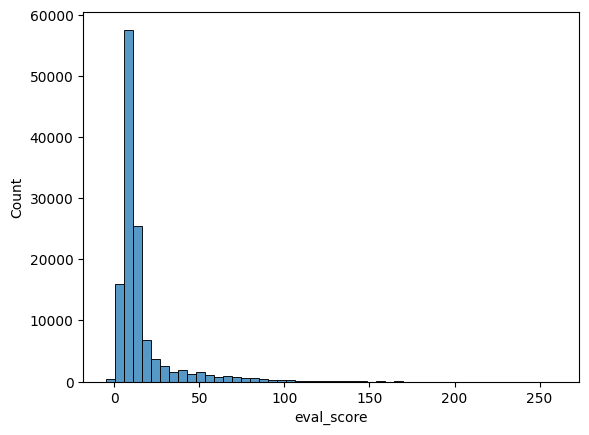

In [13]:
# plot the distribution of scores['eval_score'] as histogram
sns.histplot(scores['eval_score'], bins=50)

In [16]:
# perform k-means clustering with embeddings
K = 64
d = embeddings.shape[1]
index = faiss.IndexFlatL2(d)
index.add(embeddings)

kmeans = faiss.Kmeans(d, K, niter=300, verbose=True, nredo=5, gpu=True)
kmeans.train(embeddings)

pca = faiss.PCAMatrix(d, 2)
pca.train(embeddings)

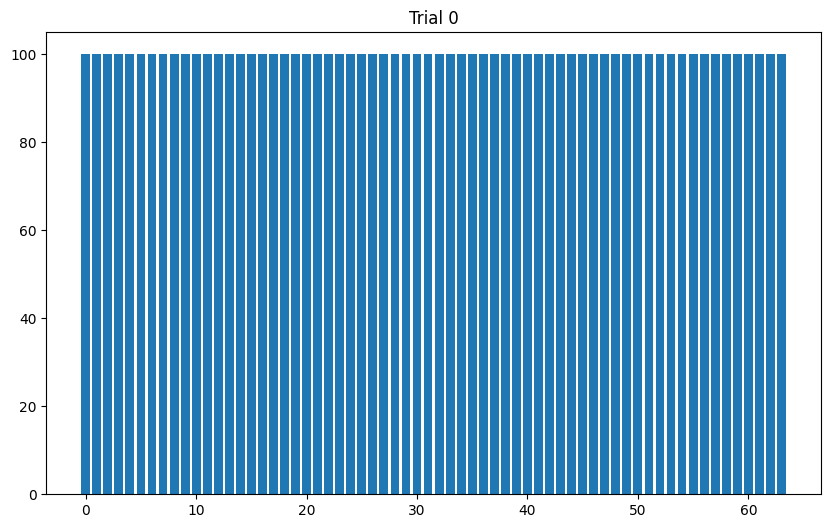

Cluster 0 score: [132 132 127 127 127 112 110 103 105 105 105 102 101 101  98  97  96  97
  92  94  91  92  91  90  90  91  88  88  85  86  86  84  83  84  84  84
  84  82  82  82  81  80  77  74  78  76  77  76  76  76  75  74  74  74
  74  72  71  72  71  66  67  69  68  66  64  66  67  66  66  64  66  64
  64  64  62  62  62  60  60  60  60  60  60  60  59  60  60  59  58  52
  56  55  56  56  55  53  55  51  54  53]
Cluster 1 score: [186 114 110 107 107 106 106 102  98  97  96  98  96  94  94  92  91  87
  89  90  89  87  84  86  84  82  83  81  71  78  80  76  76  77  77  76
  74  77  74  77  75  77  73  74  73  74  70  73  66  72  68  71  70  68
  67  70  69  69  68  68  68  66  65  66  67  65  65  63  65  61  64  62
  64  60  63  64  61  59  62  60  60  62  62  61  60  60  61  61  58  60
  59  58  59  60  58  57  56  57  55  54]
Cluster 2 score: [127 100  81  64  64  64  60  52  52  50  47  44  35  37  34  33  26  20
  18  20  16  16  16  16  15  14  14  12   4   8  14  12  12  

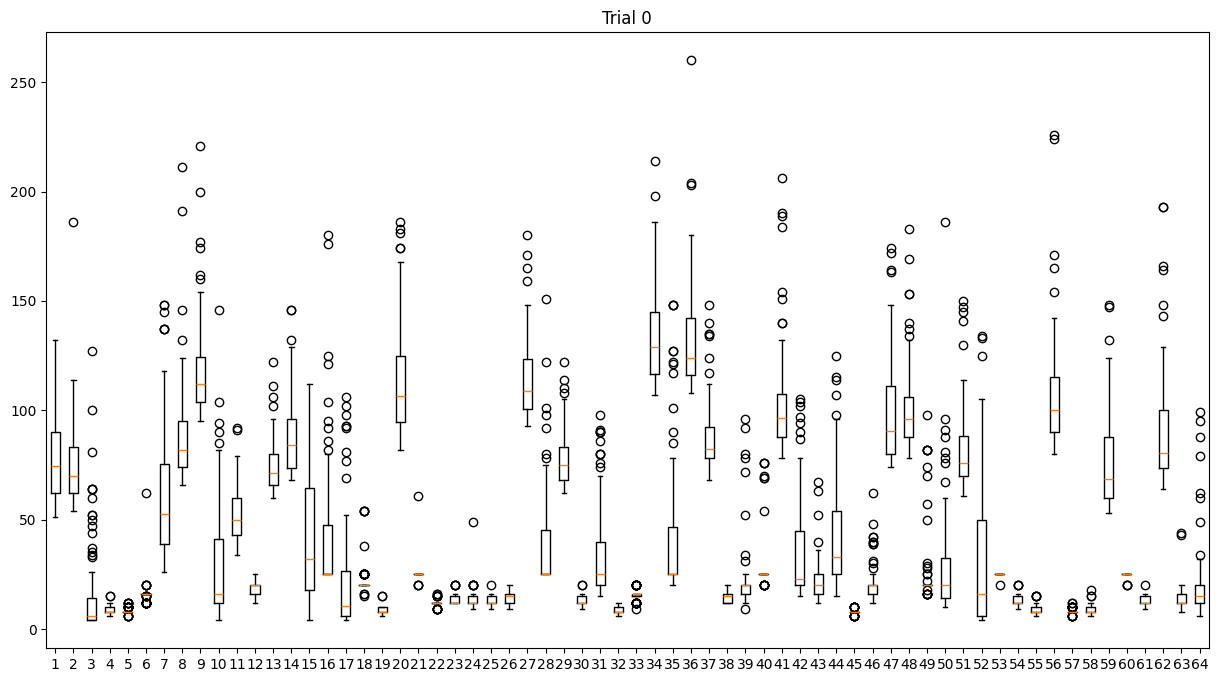

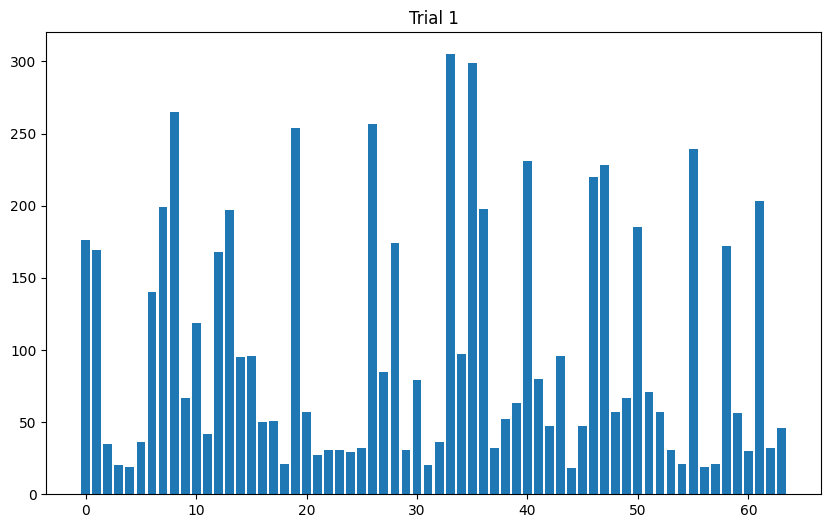

Cluster 0 score: [132 132 127 127 127 112 110 103 105 105 105 102 101 101  98  97  96  97
  92  94  91  92  91  90  90  91  88  88  85  86  86  84  83  84  84  84
  84  82  82  82  81  80  77  74  78  76  77  76  76  76  75  74  74  74
  74  72  71  72  71  66  67  69  68  66  64  66  67  66  66  64  66  64
  64  64  62  62  62  60  60  60  60  60  60  60  59  60  60  59  58  52
  56  55  56  56  55  53  55  51  54  53  54  54  54  53  47  52  50  52
  52  52  50  52  50  51  50  48  50  50  48  48  49  48  48  46  48  48
  48  48  46  48  47  44  48  46  48  46  43  47  46  46  46  45  44  44
  46  45  45  44  44  44  44  44  44  44  43  44  44  43  42  42  42  40
  40  40  39  34  40  40  36  38  37  39  36  38  34  34  38  38  37  36
  36  36  33  34  36  34  34  34  35  34  34  34  32  32  32  33  32  32
  30  29  32  30  30  29  30  26  30  26  30  30  30  30  30  25  30  28
  30  29  30  25  28  28  28  25  25  25  28  25  26  28  28  25  20  26
  25  28  25  25  25  26  24  26  

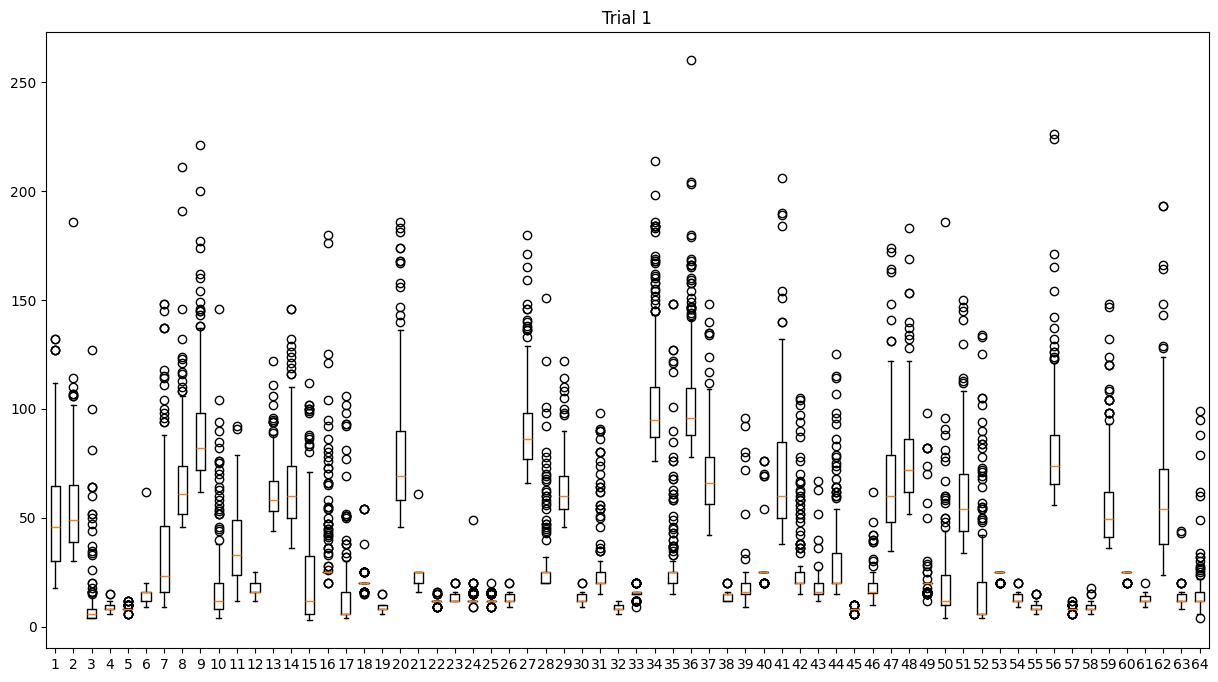

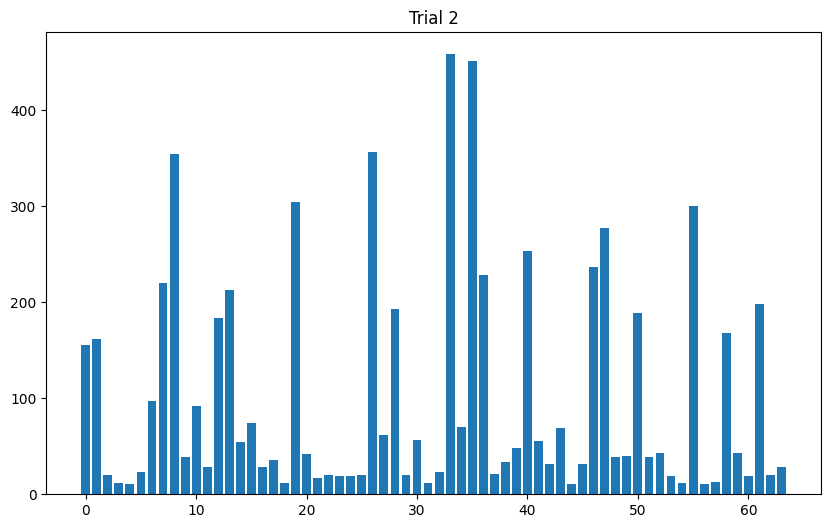

Cluster 0 score: [132 132 127 127 127 112 110 103 105 105 105 102 101 101  98  97  96  97
  92  94  91  92  91  90  90  91  88  88  85  86  86  84  83  84  84  84
  84  82  82  82  81  80  77  74  78  76  77  76  76  76  75  74  74  74
  74  72  71  72  71  66  67  69  68  66  64  66  67  66  66  64  66  64
  64  64  62  62  62  60  60  60  60  60  60  60  59  60  60  59  58  52
  56  55  56  56  55  53  55  51  54  53  54  54  54  53  47  52  50  52
  52  52  50  52  50  51  50  48  50  50  48  48  49  48  48  46  48  48
  48  48  46  48  47  44  48  46  48  46  43  47  46  46  46  45  44  44
  46  45  45  44  44  44  44  44  44  44  43  44  44  43  42  42  42  40
  40  40  39  34  40  40  36  38  37  39  36  38  34  34  38  38  37  36
  36  36  33  34  36  34  34  34  35  34  34  34  32  32  32  33  32  32
  30  29  32  30  30  29  30  26  30  26  30  30  30  30  30  25  30  28
  30  29  30  25  28  28  28  25  25  25  28  25  26  28  28  25  20  26
  25  28  25  25  25  26  24  26  

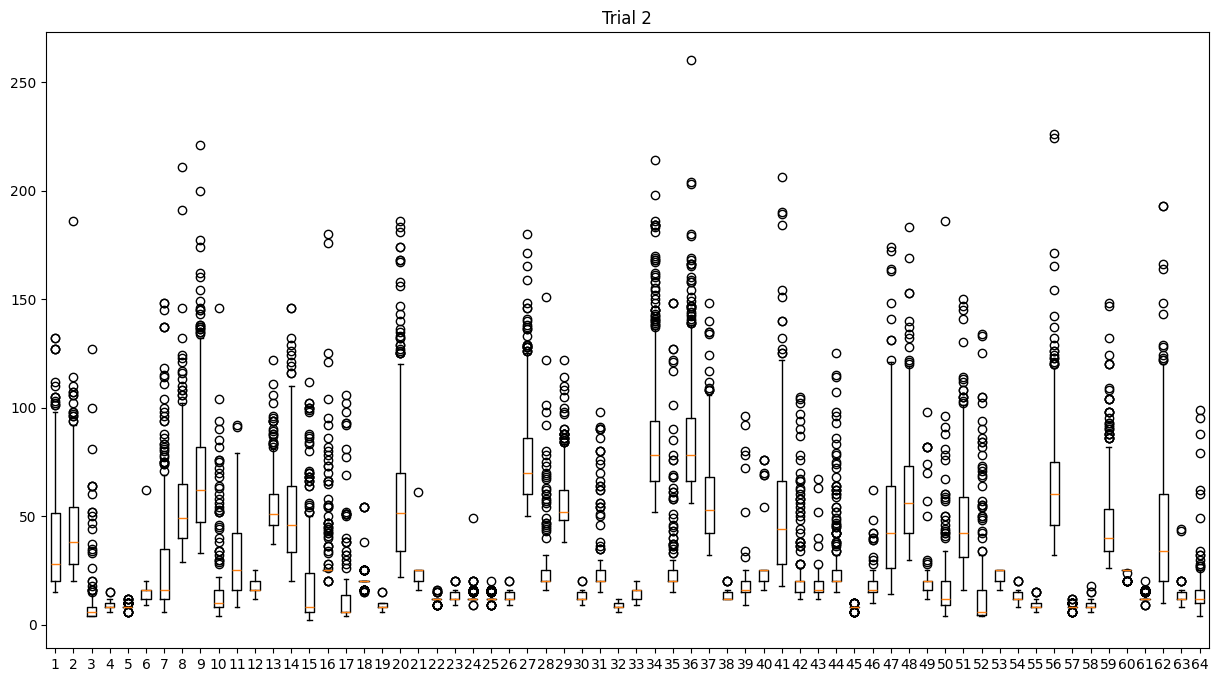

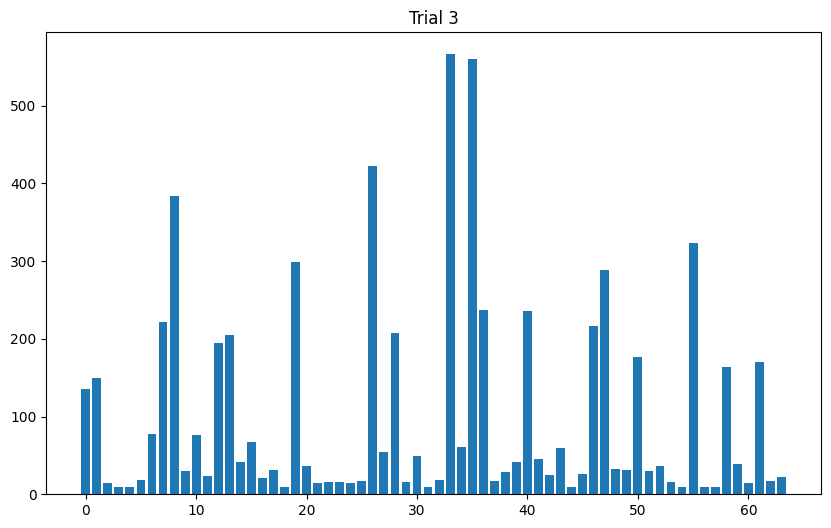

Cluster 0 score: [132 132 127 127 127 112 110 103 105 105 105 102 101 101  98  97  96  97
  92  94  91  92  91  90  90  91  88  88  85  86  86  84  83  84  84  84
  84  82  82  82  81  80  77  74  78  76  77  76  76  76  75  74  74  74
  74  72  71  72  71  66  67  69  68  66  64  66  67  66  66  64  66  64
  64  64  62  62  62  60  60  60  60  60  60  60  59  60  60  59  58  52
  56  55  56  56  55  53  55  51  54  53  54  54  54  53  47  52  50  52
  52  52  50  52  50  51  50  48  50  50  48  48  49  48  48  46  48  48
  48  48  46  48  47  44  48  46  48  46  43  47  46  46  46  45  44  44
  46  45  45  44  44  44  44  44  44  44  43  44  44  43  42  42  42  40
  40  40  39  34  40  40  36  38  37  39  36  38  34  34  38  38  37  36
  36  36  33  34  36  34  34  34  35  34  34  34  32  32  32  33  32  32
  30  29  32  30  30  29  30  26  30  26  30  30  30  30  30  25  30  28
  30  29  30  25  28  28  28  25  25  25  28  25  26  28  28  25  20  26
  25  28  25  25  25  26  24  26  

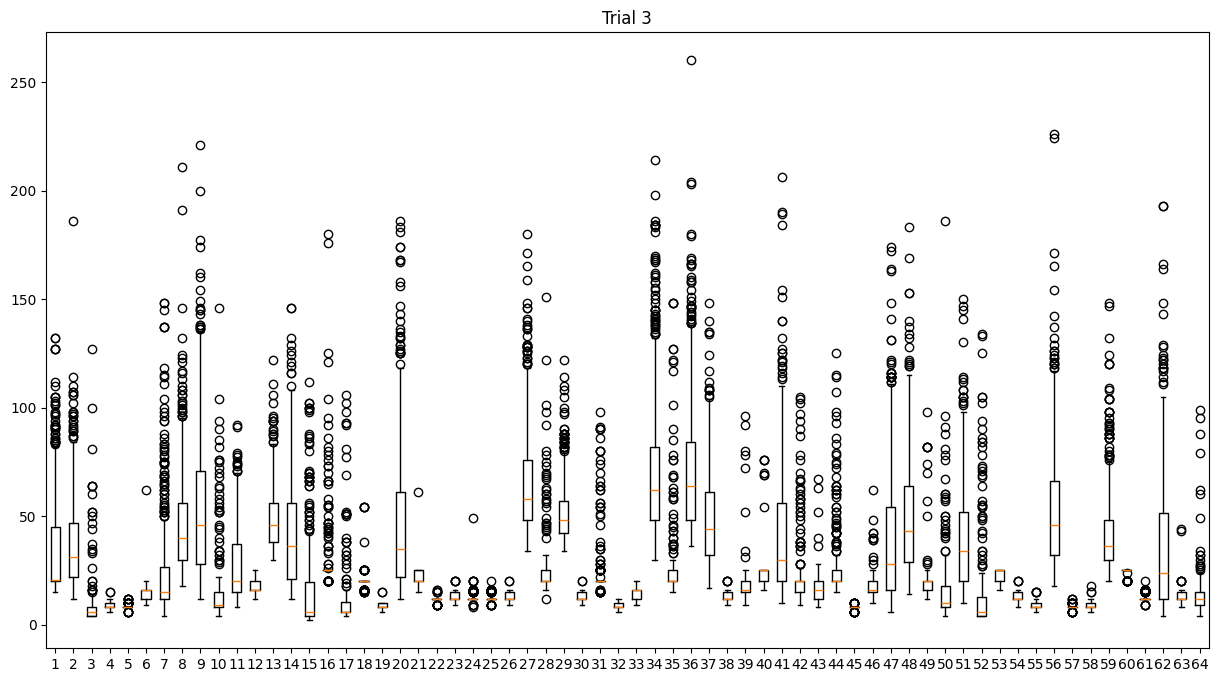

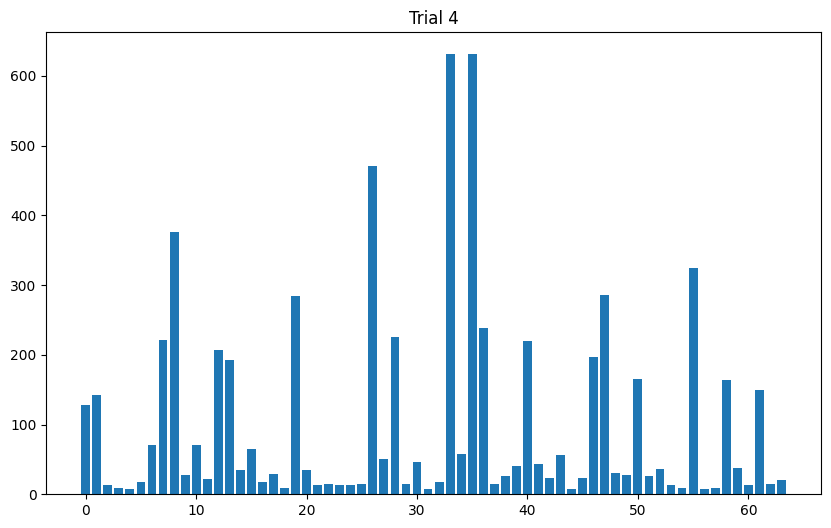

Cluster 0 score: [132 132 127 127 127 112 110 103 105 105 105 102 101 101  98  97  96  97
  92  94  91  92  91  90  90  91  88  88  85  86  86  84  83  84  84  84
  84  82  82  82  81  80  77  74  78  76  77  76  76  76  75  74  74  74
  74  72  71  72  71  66  67  69  68  66  64  66  67  66  66  64  66  64
  64  64  62  62  62  60  60  60  60  60  60  60  59  60  60  59  58  52
  56  55  56  56  55  53  55  51  54  53  54  54  54  53  47  52  50  52
  52  52  50  52  50  51  50  48  50  50  48  48  49  48  48  46  48  48
  48  48  46  48  47  44  48  46  48  46  43  47  46  46  46  45  44  44
  46  45  45  44  44  44  44  44  44  44  43  44  44  43  42  42  42  40
  40  40  39  34  40  40  36  38  37  39  36  38  34  34  38  38  37  36
  36  36  33  34  36  34  34  34  35  34  34  34  32  32  32  33  32  32
  30  29  32  30  30  29  30  26  30  26  30  30  30  30  30  25  30  28
  30  29  30  25  28  28  28  25  25  25  28  25  26  28  28  25  20  26
  25  28  25  25  25  26  24  26  

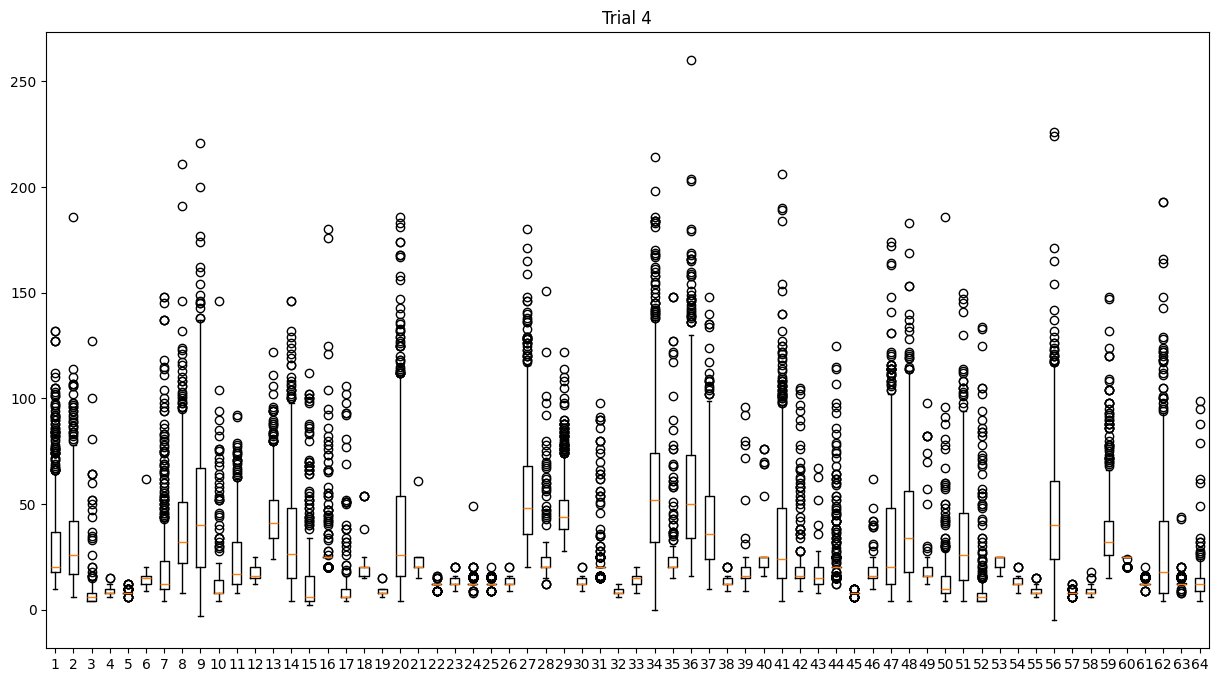

In [44]:
from collections import Counter, defaultdict
distances, indices = kmeans.index.search(embeddings, 1)
indices = indices.flatten()
# sample 100 point from each cluster and plot them in 2D with legend
sampled_indices = {i : np.array([], dtype=np.int64) for i in range(K)}
cluster2scores = {}
clusters2indices = {i : np.where(indices == i)[0] for i in range(K)}
clusters2weights = np.ones(K) / K

select_size = 100
trial = 5
for t in range(trial):
    cluster2scores = {}
    assigned_size = np.ceil(clusters2weights * (select_size * K)).astype(int)
    # plot the assigned_size with x axis as cluster index
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.bar(range(K), assigned_size)
    # with title as the current trial
    plt.title(f"Trial {t}")
    plt.show()

    for i in range(K):
        indices_i = clusters2indices[i]
        scores_i = eval_scores[indices_i]
        p = safe_softmax(scores_i)
        size = min(assigned_size[i], len(indices_i))
        indices_i_sampled = np.random.choice(indices_i, size=size, p=p, replace=False)
        sampled_indices[i] = np.concatenate([sampled_indices[i], indices_i_sampled])
        # cluster2scores[i] = eval_scores[sampled_indices[i]] / (len(sampled_indices[i]))
        cluster2scores[i] = eval_scores[sampled_indices[i]]
        
        clusters2weights[i] = np.sum(cluster2scores[i])
        clusters2indices[i] = np.setdiff1d(clusters2indices[i], indices_i_sampled)
        print(f"Cluster {i} score: {cluster2scores[i]}")
    clusters2weights /= np.sum(clusters2weights)
    # clusters2weights = safe_softmax(clusters2weights)

    # plot the distribution of cluster2scores with x axis as cluster index, y axis as the score using boxplot
    fig, ax = plt.subplots(figsize=(15, 8))
    plt.boxplot([cluster2scores[i] for i in range(K)])
    plt.title(f"Trial {t}")
    plt.show()